<img src = "../../Data/bgsedsc_0.jpg">

# Project: (K-) Nearest Neighbors


## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for grading
From more to less important:
+ Code runs
+ Probability of death for each test patient is computed
+ Accuracy of predictions for test patients is provided
+ Nearest neighbor method(s) have been used
+ Accuracy itself
+ Data preparation
+ Class imbalance management
+ Hyperparameter optimization
+ Neat and understandable code, with some titles and comments
+ Improved methods from what we discussed in class (properly explained/justified)

# Google Colab

Just run this cell if running from Google Colab, to set the correct working directory

In [ ]:
from google.colab import drive
import os
# Mount google drive if running from Google Collab
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/bgse-k-nn-death') ## Google Colab

# INTRO: Modules and work directory


We import all the modules that will be used throughout the code and we set the local working directory from which we will get the data.

In [ ]:
import os
## Work directory

## Set current directory either from Google Colab or local
os.chdir('/Users/yersivillegas/Desktop/TERM 1/CML/KNN+SVM/bgse-k-nn-death') ## Local
#os.chdir('/Volumes/GoogleDrive/Mi unidad/bgse-k-nn-death') ## Local through Drive

In [ ]:
#import auxiliar functions
import sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from utils.helper_functions import *

## Basic python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import datetime as dt
from datetime import timedelta

## Modules to deal with class imbalance
from imblearn.under_sampling import  RandomUnderSampler, ClusterCentroids, AllKNN, CondensedNearestNeighbour, InstanceHardnessThreshold
from imblearn.under_sampling import TomekLinks, NearMiss, NeighbourhoodCleaningRule, OneSidedSelection
from imblearn.over_sampling import SMOTE

## Modules for scalers, imputers and encoders 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA

## Modules for constructing Pipelines
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from pipelinehelper import PipelineHelper

## Modules to run our models
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Modules to check accuracy of our models
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score, roc_curve
from sklearn import datasets, metrics, model_selection
from sklearn.model_selection import cross_val_predict

# MANAGING DATA


## Loading and dropping useless data

We load all datasets from the beginning: training, test and extra data. Furthermore, we can already drop the columns of the variables that we didn't know when the patient entered the hospital: 

 - _DOD_
 - _LOS_
 - _DISCHTIME_
 - _DEATHTIME_

Moreover, since _DIAGNOSIS_ is a free-text column, we cannot get useful data from it and therefore, we can also drop it.

In [ ]:
# Training dataset:
data=pd.read_csv('mimic_train.csv')

# Test dataset (to produce predictions):
data_test=pd.read_csv('mimic_test_death.csv')

# Extra data of all comobirdities:
extra=pd.read_csv('extra_data/MIMIC_diagnoses.csv')

In [ ]:
## We get rid of the columns that are not going to be used.

data=data.drop(['DOD','LOS','DISCHTIME','DEATHTIME','DIAGNOSIS'], axis=1)
data_test=data_test.drop(['DIAGNOSIS'], axis=1)


## Dates

Now, we begin by working with the date-type columns of both the training and test datasets.

First, we add the _Diff_ column to the _Date of Birth_ and _ADMITTIME_ column, in order to get reasonable dates, so that we can later extract other values. Then, we compute the age of each patient by substrating the _DOB_ from the _ADMITTIME_. 

In [ ]:
## Changing the columns with dates into datetime variables, 
## taking into account the 'Diff' column that has to be applied to every date.

data['Diff']=data.apply(lambda x: timedelta(days=-x.Diff),axis=1)
data['DOB'] = data.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
data['DOB'] = data.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
data['ADMITTIME'] = data.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
data['ADMITTIME'] = data.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
data['age']=data.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)

In [ ]:
data_test['Diff']=data_test.apply(lambda x: timedelta(days=-x.Diff),axis=1)
data_test['DOB'] = data_test.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
data_test['DOB'] = data_test.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
data_test['ADMITTIME'] = data_test.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
data_test['ADMITTIME'] = data_test.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
data_test['age']=data_test.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)

Now, we can extract the hour, month and year in which each patient entered the hospital. Furthermore, we also compute whether the patient entered the hospital during the night; from 10PM to 6AM. We will later extract useful information from these created variables.

In [ ]:
## Computing year, month and hour of entry,
## along with binary-type night-time entry.

data['month'] = data['ADMITTIME'].apply(lambda x: x.month)
data['year'] = data['ADMITTIME'].apply(lambda x: x.year)
data['hour'] = data['ADMITTIME'].apply(lambda x: x.hour)
data_test['month'] = data_test['ADMITTIME'].apply(lambda x: x.month)
data_test['year'] = data_test['ADMITTIME'].apply(lambda x: x.year)
data_test['hour'] = data_test['ADMITTIME'].apply(lambda x: x.hour)
data['night_entrance']=np.where((data['hour'] > 22) | (data['hour'] < 6) , 1, 0)
data_test['night_entrance']=np.where((data_test['hour'] > 22) | (data_test['hour'] < 6) , 1, 0)

date_related_cols=['year','month','hour','night_entrance']

Finally, we can already drop the date-type columns, since we have already extracted the useful data from them.

In [ ]:
## We get rid of the columns that are not going to be used anymore.

data=data.drop(['DOB','ADMITTIME','Diff'], axis=1)
data_test=data_test.drop(['DOB','ADMITTIME','Diff'], axis=1)

## Getting useful numerical data from categorical and date-related data

Here, we are going to get new numerical variables based on the categorical and date-related ones; we will encode these variables and change their non-numerical result for their associated death rate, therefore assessing a kind of target encoding. In this way, we avoid having a very high number of features, just like we would have by creating dummies (since our data is already high-dimensional).

For each categorical variable, we will compute their mean associated to the _HOSPITAL EXPIRE FLAG_ value they have. Therefore, we will have a table with each categorical value (indexes) and their death rate (values). Hence, we just need to go over the training and the test set and, whenever we find the index, we change it for their corresponding death rate. We will do so in the following columns:
- _GENDER_
- _ADMISSION TYPE_
- _INSURANCE_
- _RELIGION_
- _MARITAL STATUS_
- _ETHNICITY_
- _FIRST CAREUNIT_

In [ ]:
## Function to compute the death rate of a variable
## and add a new column to both training and test sets

def death_rate_calc(column,target):
  col_mean=data.groupby(column).mean()[target]
  data[column]=data[column].replace(to_replace=col_mean.index,value=col_mean.values)
  data_test[column]=data_test[column].replace(to_replace=col_mean.index,value=col_mean.values)

In [ ]:
## Applying death rate function to the categoricals

cat_col=[name for name in data_test.select_dtypes(exclude=np.number).columns]
cat_col.remove('ICD9_diagnosis')
for col in cat_col:
  death_rate_calc(col,'HOSPITAL_EXPIRE_FLAG')

Finally, we will do the same with the date-related variables we developed before. First, we create a new categorical value, which represents the age range to which each patient belongs to:
- Under 30 years
- Between 30 and 60 years
- Over 60 years

Now, we encode the variable exactly as we did before.

In [ ]:
## Computing age range

data_test['age_inf']=np.where(data_test['age'] < 11000, 'under_30', '30_to_60')
data_test['age_inf']=np.where(data_test['age'] >= 22000, 'over_60', data_test['age_inf'])
data['age_inf']=np.where(data['age'] < 11000, 'under_30', '30_to_60')
data['age_inf']=np.where(data['age'] >= 22000, 'over_60', data['age_inf'])

death_rate_calc('age_inf','HOSPITAL_EXPIRE_FLAG')

Then, we will encode the rest of date-related columns we created before. Therefore, we will have the death rate associated to:
- Hour of entrance
- Month of entrance
- Year of entrance
- Entrance at night


In [ ]:
## Applying death rate function to the date-related

for col in date_related_cols:
  death_rate_calc(col,'HOSPITAL_EXPIRE_FLAG') #+'_death_rate'

## Adding the extra data

The data we have been working with only contained the diagnosis that got the patient into the hospital. However, each patient may have many other extra diagnosis, which are stored in the extra data.

We firstly merge our training data with the extra data by the _HADM ID_ columns, so that we can associate all the extra _ICD9 codes_ to the _HOSPITAL EXPIRE FLAG_ of each patient. Then, we will just do what we did with the above categorical features: change each _ICD9 code_ with its associated death rate, and we will do it for all datasets: training, test and merged.

In [ ]:
## Merging and computing death rate for the diagnosis

alldata = pd.merge(data,extra,how='left',left_on='hadm_id',right_on='HADM_ID')

In [ ]:
diag_mean = alldata.groupby('ICD9_CODE').mean()['HOSPITAL_EXPIRE_FLAG']
data['ICD9_diagnosis']=data['ICD9_diagnosis'].replace(to_replace=diag_mean.index,value=diag_mean.values) #_mean
data_test['ICD9_diagnosis']=data_test['ICD9_diagnosis'].replace(to_replace=diag_mean.index,value=diag_mean.values) #_mean
data_test['ICD9_diagnosis']=pd.to_numeric(data_test['ICD9_diagnosis']) #_mean

In [ ]:
alldata['ICD9_CODE']=alldata['ICD9_CODE'].replace(to_replace=diag_mean.index,value=diag_mean.values)

Now, once we have changed the _ICD9 code_ for their associated death rate, we will repeat the procedure and now compute the following: for each _HADM ID_, we will compute the death rate corresponding to the mean of means of all the diagnosis that patient had in that hospital stay. Furthermore, we can also compute the maximum death rate; meaning, the diagnose that had the highest death rate. Thus, we will add these two columns:
- _mean of means_ 
- _max of means_

to both training and test set. In the test set, for those _HADM ID_ which did not appear in the training set, we will add a Non-Numerical Value (_NaN_), since we do not have the correct information. Hence, with the upcoming preprocessing that we will see, these _NaN_ will be correctly dealt with.

In [ ]:
## Mean() and max() of the death rates for each diagnosis
## that a patient has in each stay

mean_of_means=alldata.groupby('HADM_ID').mean()['ICD9_CODE']
max_of_all=alldata.groupby('HADM_ID').max()
max_of_means=max_of_all['ICD9_CODE']

In [ ]:
data['mean_of_means']=data['hadm_id'].replace(to_replace=mean_of_means.index,value=mean_of_means.values)
data_test['mean_of_means']=data_test['hadm_id'].replace(to_replace=mean_of_means.index,value=mean_of_means.values)
data_test['mean_of_means']=np.where(data_test['mean_of_means'] > 1, np.nan, data_test['mean_of_means'])

In [ ]:
data['max_of_means']=data['hadm_id'].replace(to_replace=max_of_means.index,value=max_of_means.values)
data_test['max_of_means']=data_test['hadm_id'].replace(to_replace=max_of_means.index,value=max_of_means.values)
data_test['max_of_means']=np.where(data_test['max_of_means'] > 1, np.nan, data_test['max_of_means'])

Finally, we can also compute the number of comoborbidities a patient had for each _HADM ID_; that is, for each stay in the hospital. We count the number of times each _HADM ID_ appears in the extra data and we add it to both training and test set.

In [ ]:
## Number of comorbidites in each hospital stay

num_of_comob=extra['HADM_ID'].value_counts()
data['num_of_comob']=data['hadm_id'].replace(to_replace=num_of_comob.index,value=num_of_comob.values)
data_test['num_of_comob']=data_test['hadm_id'].replace(to_replace=num_of_comob.index,value=num_of_comob.values)

## Training sets and checking class imbalance

When we are done with working with our data, we can then drop the target variable we are going to predict and create the training _X_ and _y_ sets. Then, we will produce a small plot in which we will be able to see the class imbalance for what will be our target variable.

In [ ]:
X_train = data.drop(['HOSPITAL_EXPIRE_FLAG'], axis=1) 
y_train = data["HOSPITAL_EXPIRE_FLAG"] 

As we can see, the majority class is the people who does NOT die, whereas the people who actually die clearly are a minority. Hence, we will later deal with this and correct it.

<AxesSubplot:>

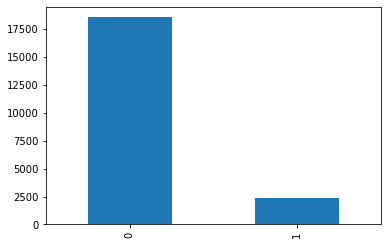

In [ ]:
y_train.value_counts().plot(kind="bar")

# PREPROCESSING


With all our managed data, we will now deal with all the preprocessing of data required before performing our model. In order to do that, we will put all the methods together with the Pipeline module.

Since we do not have categorical features anymore, we just have to create a Pipeline for the numerical data. 

We will first impute all the _NaN_ with the _IterativeImputer_. This imputer changes the _NaN_'s with the mean of the corresponding column. However, it goes through all the features in the data in order to just use the correct observations for each _NaN_. Therefore, it improves the performance of the _SimpleImputer_, which just computes the column mean without taking into account all other features.

Then, we will use the _Standard Scaler_ in order to scale the data, just like we did in class. After having tried other scalers, like the _MinMaxScaler_, the standard one was the one with the best performance.


In [ ]:
## We define the Pipelines for both types of features

numeric_transformer = Pipeline(steps=[
       ('imputer', IterativeImputer())
      ,('scaler', StandardScaler())
      
])

Finally, we will put the numerical Pipeline into a _ColumnTransformer_, which applies the different methods in the Pipeline to all columns; we define it as _preprocessor_, which will be the only step of our _pipeline_ variable. We check that our categorical features are gone by creating a list of the numerical and categorical columns in our data, and see that the categorical list is empty.

In [ ]:
## Define lists with the numerical and categorical values separately

num_feat=[name for name in data_test.select_dtypes(include=np.number).columns]
cat_feat=[name for name in data_test.select_dtypes(exclude=np.number).columns]

## We define the preprocessor

preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, num_feat)
]) 

## Define the pipeline with the preprocessor

pipeline = Pipeline(steps = [('preprocessor', preprocessor)])

# KNN model

## Defining the model





We begin by defining our KNN model with the _KNeighborsClassifier_ function. We will run this model with the _brute_ algorithm, instead of using the _KD Tree_ or _Ball Tree_ algorithms. The reasons are the following:

- First, we can quickly discard the _KD Tree_ algorithm, since we are working with high-dimensional data. _KD Tree_ works better with medium-dimensional data ($2^d << N$).
- Then, we can also discard the _Ball Tree_ algorithm, even though it can be used with high-dimensional data. The reason is because it is highly depends on data having a structure that allows building the minimum hyperspheres. For noisy and/or high-dimensional data, it may need a higher number of balls, and therefore provides little gains from the  _brute_ algorithm.

Then, we define the parameters that we are going to go through in the _GridSearch_ in order to find the best value of each one of them:

- Number of nearest neighbors: list of integer numbers that will determine how many neighbors should the model check everytime. A way to know an approximate range of optimality for the value of K is to do the square root of the number of observations. Therefore, depending on the method we use to deal with class imbalance, we will use a higher or lower value of K, as we will later see.
- Metric: since we are working with the _brute_ algorithm, we can get its valid metrics and check them all.
- Weights: we will try to run the default _uniform_ feature and the one that weights all the measures it does.

Furthermore, we will work with the basic score for the Area Under the Curve (_roc auc_) and also with a weighted version of it (_roc auc ovr weighted_), in order to also take into account the weights of the results.

In [ ]:
## Defining the KNeighborsClassifier()

MyKNN = KNeighborsClassifier()

In [ ]:
## Metrics for the brute algorithm
metrics=sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute'])
metrics.remove('precomputed')

## Scoring of the GridSearch
scoring = {"auc_ovr": "roc_auc_ovr_weighted", "auc": 'roc_auc'}


Therefore, the only feature left to define is the method to deal with class-imbalance: over-sampling or under-sampling. They both have different pros and cons:

- On one hand, while over-sampling does not lose information and therefore performs a better training of the model, it can bring problems of over-fitting, since it has too many new samples.
- On the other hand, undersampling does not overfit the model, but in exchange of losing too many information and therefore, a worse training performance. 

Hence, we could try both methods and see their different results.

In [ ]:
undersampler=RandomUnderSampler()
oversampler=SMOTE()

## Fitting the model and checking performance

First, we fit the pipeline we created before with our training X, in order to do all the preprocessing to it. We use _fit  transform_ and we assign it to a new variable.

In [ ]:
X_p = pipeline.fit_transform(X_train)


Then, with the preprocessed data, we do the two sampling methods to both training X and y. We can check the length of both oversampled and undersampled data and thus, compute the optimal number of nearest neighbors for each of them:

- With under-sampling, we get 4690 observations (rows) and thus, the optimal K would be around 70.
- With over-sampling, there are 37080 observations. Hence, the optimal K would be around 190.

### Over-sampling


We begin by resampling the training data and checking that now, both classes are equally balanced. We can also check the shape of the new resampled data, to see that we have the right amount of observations and features.

In [ ]:
X_p_o, y_train_o = oversampler.fit_resample(X_p, y_train)

(37080, 44)


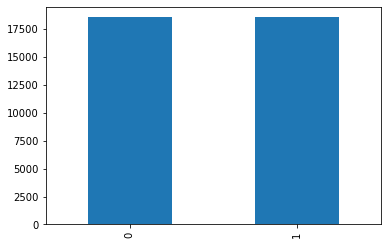

In [ ]:
y_train_o.value_counts().plot(kind="bar")
print(X_p_o.shape)

Now, we define the grid of values that we will use for the over-sampled data, with the aforementioned optimal value for the number of nearest neighbors.

In [ ]:
## Number of nearest neighbors used for over-sampling
over_n=[170,180,190,200,210]

## GridSearch parameters for over-sampling
grid_values_o = {'algorithm':['brute'],
               'n_neighbors':over_n,'weights':['uniform','distance']
               , 'metric':metrics}

Finally, we define the _GridSearch_ we will run to get the optimal values for each parameter and fit it with our over-sampled training data. Then, we print the best parameters that it finds.

In [ ]:
## GridSearch defined, fitted and its best parameters printed

grid_knn_acc_o = GridSearchCV(MyKNN, param_grid = grid_values_o,scoring = scoring, refit='auc',cv=10, verbose=3)
grid_knn_acc_o.fit(X_p_o,y_train_o)
print('Best algorithm : '+ str(grid_knn_acc_o.best_estimator_.algorithm))
print('Best k parameter : '+ str(grid_knn_acc_o.best_estimator_.n_neighbors))
print('Best weights parameter : '+ str(grid_knn_acc_o.best_estimator_.weights))
print('Best k parameter : '+ str(grid_knn_acc_o.best_estimator_.metric))
print("Best parameter (CV score=%0.3f):" % grid_knn_acc_o.best_score_)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 1/10] END algorithm=brute, metric=cityblock, n_neighbors=170, weights=uniform; auc: (test=0.944) auc_ovr: (test=0.944) total time=   5.0s
[CV 2/10] END algorithm=brute, metric=cityblock, n_neighbors=170, weights=uniform; auc: (test=0.959) auc_ovr: (test=0.959) total time=   4.2s
[CV 3/10] END algorithm=brute, metric=cityblock, n_neighbors=170, weights=uniform; auc: (test=0.965) auc_ovr: (test=0.965) total time=   4.2s
[CV 4/10] END algorithm=brute, metric=cityblock, n_neighbors=170, weights=uniform; auc: (test=0.967) auc_ovr: (test=0.967) total time=   4.2s
[CV 5/10] END algorithm=brute, metric=cityblock, n_neighbors=170, weights=uniform; auc: (test=0.962) auc_ovr: (test=0.962) total time=   4.3s
[CV 6/10] END algorithm=brute, metric=cityblock, n_neighbors=170, weights=uniform; auc: (test=0.968) auc_ovr: (test=0.968) total time=   4.3s
[CV 7/10] END algorithm=brute, metric=cityblock, n_neighbors=170, weights=uniform; au

Now, we assess the model's performance by predicting with the obtained optimal values on our over-sampled training X. We use some of the metrics from sklearn and print the obtained results.

In [ ]:
## Predictions from the training set

insample_y_pred_o = grid_knn_acc_o.predict(X_p_o)

## Accuracy of those predictions

print('Accuracy Score : ' + str(accuracy_score(y_train_o,insample_y_pred_o)))
print('Precision Score : ' + str(precision_score(y_train_o,insample_y_pred_o)))
print('Recall Score : ' + str(recall_score(y_train_o,insample_y_pred_o)))
print('F1 Score : ' + str(f1_score(y_train_o,insample_y_pred_o)))

Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0


Finally, we evaluate the performance of our model by plotting the Area Under the Curve (AUC) with one of the _Help functions_ from _Utils_: _get auc_. We use _Cross Validation_, with the optimal parameters obtained through the _GridSearch_, to obtain the predictions from the over-sampled training set.

AUC:  0.9836506797745683


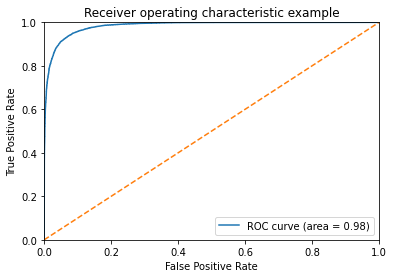

In [ ]:
## Defining the KNN model with the optimal results,
## apply cross-validation to get probabilities on the training set
## and plot the AUC.

MyKNN_optimal_o = KNeighborsClassifier(n_neighbors=170,algorithm='brute',metric='cosine',weights='distance')
                                     
y_probs_KNN_o = cross_val_predict(MyKNN_optimal_o, X_p_o, y_train_o,
                            method='predict_proba',cv=5)

get_auc(y=y_train_o, y_pred_probabilities=y_probs_KNN_o, class_labels=['Alive','Dead'], column=1, plot=True) # Help function

### Under-sampling

We do the same as before. Begin by resampling the training data and checking that now, both classes are equally balanced. We also check the shape of the new resampled data, to see that we have the right amount of observations and features.

In [ ]:
X_p_u, y_train_u = undersampler.fit_resample(X_p, y_train)

(4690, 44)


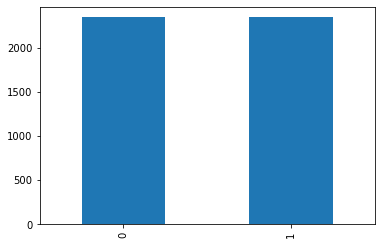

In [ ]:
y_train_u.value_counts().plot(kind="bar")
print(X_p_u.shape)

Now, we define the grid of values that we will use for the under-sampled data, with the aforementioned optimal value for the number of nearest neighbors.

In [ ]:
## Number of nearest neighbors used for under-sampling
under_n=list(range(50,80))

## GridSearch parameters for under-sampling
grid_values_u = {'algorithm':['brute'],
               'n_neighbors':under_n,'weights':['uniform','distance']
               , 'metric':metrics}

Finally, we define the _GridSearch_ we will run to get the optimal values for each parameter and fit it with our under-sampled training data. Then, we print the best parameters that it finds.

In [ ]:
## GridSearch defined, fitted and its best parameters printed

grid_knn_acc_u = GridSearchCV(MyKNN, param_grid = grid_values_u,scoring = scoring, refit='auc',cv=10, verbose=3)
grid_knn_acc_u.fit(X_p_u,y_train_u)
print('Best algorithm : '+ str(grid_knn_acc_u.best_estimator_.algorithm))
print('Best k parameter : '+ str(grid_knn_acc_u.best_estimator_.n_neighbors))
print('Best weights parameter : '+ str(grid_knn_acc_u.best_estimator_.weights))
print('Best k parameter : '+ str(grid_knn_acc_u.best_estimator_.metric))
print("Best parameter (CV score=%0.3f):" % grid_knn_acc_u.best_score_)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
[CV 1/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (test=0.920) auc_ovr: (test=0.920) total time=   0.1s
[CV 2/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (test=0.944) auc_ovr: (test=0.944) total time=   0.1s
[CV 3/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (test=0.926) auc_ovr: (test=0.926) total time=   0.1s
[CV 4/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (test=0.945) auc_ovr: (test=0.945) total time=   0.1s
[CV 5/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (test=0.935) auc_ovr: (test=0.935) total time=   0.1s
[CV 6/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (test=0.935) auc_ovr: (test=0.935) total time=   0.1s
[CV 7/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (t

Again, we assess the model's performance by predicting with the obtained optimal values on our under-sampled training X. We use some of the metrics from sklearn and print the obtained results.

In [ ]:
## Predictions from the training set

insample_y_pred_u = grid_knn_acc_u.predict(X_p_u)

## Accuracy of those predictions
print('Accuracy Score : ' + str(accuracy_score(y_train_u,insample_y_pred_u)))
print('Precision Score : ' + str(precision_score(y_train_u,insample_y_pred_u)))
print('Recall Score : ' + str(recall_score(y_train_u,insample_y_pred_u)))
print('F1 Score : ' + str(f1_score(y_train_u,insample_y_pred_u)))

Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0


Finally, we evaluate the performance of our model by plotting the Area Under the Curve (AUC) with one of the _Help functions_ from _Utils_: _get auc_. We use _Cross Validation_, with the optimal parameters obtained through the _GridSearch_, to obtain the predictions from the under-sampled training set.

AUC:  0.9402685021435618


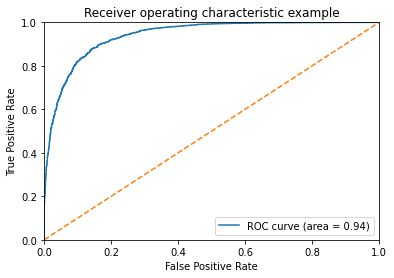

In [ ]:
## Defining the KNN model with the optimal results,
## apply cross-validation to get probabilities on the training set
## and plot the AUC.

MyKNN_optimal_u = KNeighborsClassifier(n_neighbors=71,algorithm='brute',metric='cityblock',weights='distance')
                                     
y_probs_KNN_u = cross_val_predict(MyKNN_optimal_u, X_p_u, y_train_u,
                            method='predict_proba',cv=5)

get_auc(y=y_train_u, y_pred_probabilities=y_probs_KNN_u, class_labels=['Alive','Dead'], column=1, plot=True) # Help function

## Assessing predictions with the model

First, we apply the preprocessing to the test set and define a reweight function, so that the predictions that we will later produce take into account the balancing of our classes.

In [ ]:
test_p = pipeline.transform(data_test)

In [ ]:
q1 = y_train.sum()/len(y_train)
def reweight(pi,q1,r1):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

### Predictions from over-sampling

We get our predictions for the over-sampled data and define the over-sampled parameter that the reweight function will take.

In [ ]:
## Get the predictions of the test set
y_pred_o=grid_knn_acc_o.predict_proba(test_p)

In [ ]:
## the correction factor: 
r1_o = y_train_o.sum()/len(y_train_o)

Now, we just create the file with the _icustay id_ and the predicted probabilities of death. We apply the reweighting function to the obtained results.

In [ ]:
## Add our predictions to the result DataFrame we will use
## to create our csv of results

test_kaggle_o = data_test[['icustay_id']] ## The unique ID
test_kaggle_o["HOSPITAL_EXPIRE_FLAG"]=y_pred_o[:,1]

# Apply reweight
test_kaggle_o["HOSPITAL_EXPIRE_FLAG"] = test_kaggle_o["HOSPITAL_EXPIRE_FLAG"].apply(reweight,args=(q1,r1_o))

test_kaggle_o.head()


<ipython-input-59-7ea90027129b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kaggle_o["HOSPITAL_EXPIRE_FLAG"]=y_pred_o[:,1]
<ipython-input-59-7ea90027129b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kaggle_o["HOSPITAL_EXPIRE_FLAG"] = test_kaggle_o["HOSPITAL_EXPIRE_FLAG"].apply(reweight,args=(q1,r1_o))


,icustay_id,HOSPITAL_EXPIRE_FLAG
0,208169,0.005264
1,251754,0.071913
2,242171,0.047333
3,263035,0.652758
4,279388,0.193565


In [ ]:
## Create the csv with our results

test_kaggle_o.to_csv("KNN_pred_oversampling.csv", index = False)

After submitting the file to Kaggle, the score obtained with 50% of the test data is: 0.86187

### Predictions with under-sampling

We get our predictions for the under-sampled data and define the under-sampled parameter that the reweight function will take.

In [ ]:
## Get the predictions of the test set
y_pred_u=grid_knn_acc_u.predict_proba(test_p)

In [ ]:
## the correction factor: 
r1_u = y_train_u.sum()/len(y_train_u)

Now, we just create the file with the _icustay id_ and the predicted probabilities of death. We apply the reweighting function to the obtained results.

In [ ]:
## Add our predictions to the result DataFrame we will use
## to create our csv of results

test_kaggle_u = data_test[['icustay_id']] ## The unique ID
test_kaggle_u["HOSPITAL_EXPIRE_FLAG"]=y_pred_u[:,1]

# Apply reweight
test_kaggle_u["HOSPITAL_EXPIRE_FLAG"] = test_kaggle_u["HOSPITAL_EXPIRE_FLAG"].apply(reweight,args=(q1,r1_u))
test_kaggle_u.head()

<ipython-input-63-4273b4f9d7b1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kaggle_u["HOSPITAL_EXPIRE_FLAG"]=y_pred_u[:,1]
<ipython-input-63-4273b4f9d7b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kaggle_u["HOSPITAL_EXPIRE_FLAG"] = test_kaggle_u["HOSPITAL_EXPIRE_FLAG"].apply(reweight,args=(q1,r1_u))


,icustay_id,HOSPITAL_EXPIRE_FLAG
0,208169,0.005568
1,251754,0.060770
2,242171,0.016402
3,263035,0.131047
4,279388,0.061588


In [ ]:
## Create the csv with our results

test_kaggle_u.to_csv("KNN_pred_undersampling1R.csv", index = False)

After submitting the file to Kaggle, the score obtained with 50% of the test data is: 0.86873

# SVM model

## Defining the model

We begin by defining our SVM model with the SVC function. We will run this model enabling the probability estimates.

Then, we define the parameters that we are going to go through in the _GridSearch_ in order to find the best value of each one of them:

- Cost parameter: list of integer numbers that will as a regularization parameter to prevent overfitting.
- Kernel: the Kernel inner product function. We will try the four options that sklearn provides: _linear_, _poly_, _rbf_ and _sigmoid_.
- Gamma: we try several values of the Kernel coefficient for _poly_, _rbf_ and _sigmoid_.

Furthermore, we will work with the basic score for the Area Under the Curve (_roc auc_) and also with a weighted version of it (_roc auc ovr weighted_), in order to also take into account the weights of the results.

In [ ]:
## We assign to a variable the 'SVC' function

MySVC = SVC(probability=True)

In [ ]:
# We set the values that will be tested through the GridSearch
grid_values_SVM = {'C':[0.1, 1, 5, 10], 'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
                   'gamma':[0.03,0.1,0.25,0.5,0.75], }
scoring = {"auc_ovr": "roc_auc_ovr_weighted", "auc": 'roc_auc'}


Therefore, the only feature left to define is the method to deal with class-imbalance. In this case, we will only use under-sampling, since SVM has a much higher computational time and thus, performs better with a smaller number of samples. With a lower number of observations, we can try more parameters and therefore obtain a better model.

In [ ]:
undersampler=RandomUnderSampler()

## Fitting the model and checking performance

First, we fit the pipeline we created before with our training X, in order to do all the preprocessing to it. We use _fit  transform_ and we assign it to a new variable.

In [ ]:
X_p = pipeline.fit_transform(X_train)

Now, we resample the training data and we check that now, both classes are equally balanced. We also check the shape of the new resampled data, to see that we have the right amount of observations and features.

In [ ]:
X_p_u, y_train_u = undersampler.fit_resample(X_p, y_train)

(4690, 44)


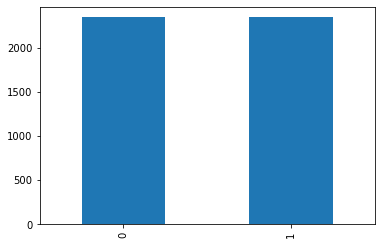

In [ ]:
y_train_u.value_counts().plot(kind="bar")
print(X_p_u.shape)

Finally, we define the GridSearch we will run to get the optimal values for each parameter and fit it with our under-sampled training data. Then, we print the best parameters that it finds.

In [ ]:
## GridSearch defined, fitted and its best parameters printed

grid_knn_acc_SVC = GridSearchCV(MySVC, param_grid = grid_values_SVM,scoring = scoring, refit='auc',cv=5, verbose=3)
grid_knn_acc_SVC.fit(X_p_u,y_train_u)
print('Best cost parameter : '+ str(grid_knn_acc_SVC.best_estimator_.C))
print('Best kernel : '+ str(grid_knn_acc_SVC.best_estimator_.kernel))
print('Best gamma : '+ str(grid_knn_acc_SVC.best_estimator_.gamma))
print("Best parameter (CV score=%0.3f):" % grid_knn_acc_SVC.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END C=0.1, gamma=0.03, kernel=linear; auc: (test=0.937) auc_ovr: (test=0.937) total time=   1.2s
[CV 2/5] END C=0.1, gamma=0.03, kernel=linear; auc: (test=0.953) auc_ovr: (test=0.953) total time=   1.2s
[CV 3/5] END C=0.1, gamma=0.03, kernel=linear; auc: (test=0.952) auc_ovr: (test=0.952) total time=   1.2s
[CV 4/5] END C=0.1, gamma=0.03, kernel=linear; auc: (test=0.959) auc_ovr: (test=0.959) total time=   1.2s
[CV 5/5] END C=0.1, gamma=0.03, kernel=linear; auc: (test=0.943) auc_ovr: (test=0.943) total time=   1.2s
[CV 1/5] END C=0.1, gamma=0.03, kernel=poly; auc: (test=0.925) auc_ovr: (test=0.925) total time=   1.9s
[CV 2/5] END C=0.1, gamma=0.03, kernel=poly; auc: (test=0.942) auc_ovr: (test=0.942) total time=   2.0s
[CV 3/5] END C=0.1, gamma=0.03, kernel=poly; auc: (test=0.936) auc_ovr: (test=0.936) total time=   2.0s
[CV 4/5] END C=0.1, gamma=0.03, kernel=poly; auc: (test=0.947) auc_ovr: (test=0.947) total time=

Now, we assess the model's performance by predicting with the obtained optimal values on our under-sampled training X. We use some of the metrics from sklearn and print the obtained results.

In [ ]:
## Predictions from the training set
insample_y_pred_SVC = grid_knn_acc_SVC.predict(X_p_u)

## Accuracy of those predictions
print('Accuracy Score : ' + str(accuracy_score(y_train_u,insample_y_pred_SVC)))
print('Precision Score : ' + str(precision_score(y_train_u,insample_y_pred_SVC)))
print('Recall Score : ' + str(recall_score(y_train_u,insample_y_pred_SVC)))
print('F1 Score : ' + str(f1_score(y_train_u,insample_y_pred_SVC)))

Accuracy Score : 0.8825159914712154
Precision Score : 0.87375
Recall Score : 0.8942430703624733
F1 Score : 0.8838777660695469


Finally, we evaluate the performance of our model by plotting the Area Under the Curve (AUC) with one of the _Help functions_ from _Utils_: _get auc_. We use _Cross Validation_, with the optimal parameters obtained through the _GridSearch_, to obtain the predictions from the under-sampled training set.

AUC:  0.9499940443987798


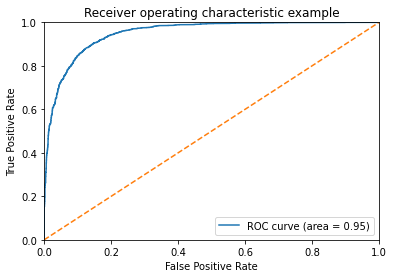

In [ ]:
## Defining the SVM model with the optimal results,
## apply cross-validation to get probabilities on the training set
## and plot the AUC.

MySVC_optimal=SVC(C=0.1, kernel='linear',gamma=0.03,probability=True)

y_probs_SVC = cross_val_predict(MySVC_optimal, X_p_u, y_train_u,method='predict_proba',cv=5)

get_auc(y=y_train_u, y_pred_probabilities=y_probs_SVC, class_labels=['Alive','Dead'], column=1, plot=True) # Help function

## Assessing predictions with the model

First, we apply the preprocessing to the test set and define a reweight function, so that the predictions that we will later produce take into account the balancing of our classes.

In [ ]:
test_p = pipeline.transform(data_test)


In [ ]:
q1 = y_train.sum()/len(y_train)
def reweight(pi,q1,r1):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

We get our predictions for the under-sampled data and define the under-sampled parameter that the reweight function will take.

In [ ]:
## Get the predictions of the test set
y_pred_SVC=grid_knn_acc_SVC.predict_proba(test_p)

In [ ]:
## the correction factor: 
r1_u = y_train_u.sum()/len(y_train_u)

Now, we just create the file with the _icustay id_ and the predicted probabilities of death. We apply the reweighting function to the obtained results.

In [ ]:
## Add our predictions to the result DataFrame we will use
## to create our csv of results

test_kaggle_SVM = data_test[['icustay_id']] ## The unique ID
test_kaggle_SVM["HOSPITAL_EXPIRE_FLAG"]=y_pred_SVC[:,1]

# Apply reweight
test_kaggle_SVM["HOSPITAL_EXPIRE_FLAG"] = test_kaggle_SVM["HOSPITAL_EXPIRE_FLAG"].apply(reweight,args=(q1,r1_u))
test_kaggle_SVM.head()


<ipython-input-37-961a67f9bb4f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kaggle_SVM["HOSPITAL_EXPIRE_FLAG"]=y_pred_SVC[:,1]
<ipython-input-37-961a67f9bb4f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kaggle_SVM["HOSPITAL_EXPIRE_FLAG"] = test_kaggle_SVM["HOSPITAL_EXPIRE_FLAG"].apply(reweight,args=(q1,r1_u))


,icustay_id,HOSPITAL_EXPIRE_FLAG
0,208169,0.007978
1,251754,0.014823
2,242171,0.002437
3,263035,0.151359
4,279388,0.022237


In [ ]:
## Create the csv with our results

test_kaggle_SVM.to_csv("SVM_pred.csv", index = False)

After submitting the file to Kaggle, the score obtained with 50% of the test data is: 0.84699